## Setup

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix

## Preparing the data

In [2]:
dataframe = pd.read_csv("data.csv")
dataframe = dataframe[['AGE','IS_READMISSION']]

In [3]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 27279 samples for training and 6820 for validation


In [4]:
y_test = val_dataframe['IS_READMISSION'].values

In [5]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("IS_READMISSION")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [6]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [7]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


## Build a model

In [13]:
# Numerical features
age = keras.Input(shape=(1,), name="AGE")

all_inputs = [
    age
]

# Numerical features
age_encoded = encode_numerical_feature(age, "AGE", train_ds)

all_features = layers.concatenate(
    [
        age_encoded,
    ]
)
x = layers.Dense(2, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

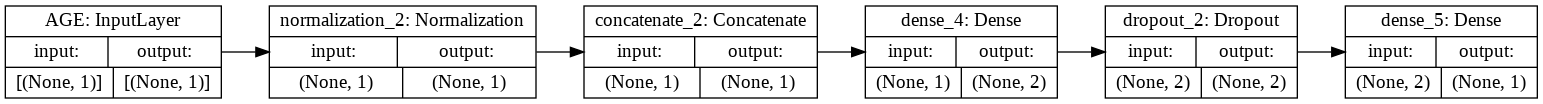

In [14]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Train the model

In [15]:
model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
853/853 [==============================] - 2s 2ms/step - loss: 0.4673 - accuracy: 0.9214 - val_loss: 0.3097 - val_accuracy: 0.9254
Epoch 2/5
853/853 [==============================] - 2s 2ms/step - loss: 0.3258 - accuracy: 0.9232 - val_loss: 0.2701 - val_accuracy: 0.9254
Epoch 3/5
853/853 [==============================] - 2s 2ms/step - loss: 0.3017 - accuracy: 0.9232 - val_loss: 0.2686 - val_accuracy: 0.9254
Epoch 4/5
853/853 [==============================] - 2s 2ms/step - loss: 0.2884 - accuracy: 0.9232 - val_loss: 0.2670 - val_accuracy: 0.9254
Epoch 5/5
853/853 [==============================] - 2s 2ms/step - loss: 0.2810 - accuracy: 0.9232 - val_loss: 0.2665 - val_accuracy: 0.9254


In [16]:
predictions = model.predict(val_ds)
y_pred = predictions.flatten()

In [17]:
def cls(x):
  if x <0.5:
    return 0
  if x >=0.5:
    return 1

In [18]:
vfunc = np.vectorize(cls)
y_pred = vfunc(y_pred)

In [19]:
confusion_matrix(y_test,y_pred)

array([[6311,    0],
       [ 509,    0]])